In [40]:
import numpy as np
import math
from scipy.integrate import solve_ivp
# import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline
# %matplotlib notebook 
#TODO: fix animation ploting
# %matplotlib widget
# %matplotlib ipympl

In [41]:
#TODO: change to path dependant on R, r and d like in paper
def path(p):
    x = 53 + 17.7 * (math.cos(p) - math.sin(p))
    y = 86.6 * math.sin(p/2)
    z = 53 + 17.7 * (math.cos(p) + math.sin(p))
    return np.array([x, y, z])

def path_p(p):
    x_p = 17.7 * (-math.sin(p) - math.cos(p))
    y_p = 43.3 * math.cos(p/2)
    z_p = 17.7 * (math.cos(p) - math.sin(p))
    return np.array([x_p, y_p, z_p])

def path_pp(p):
    x_pp = 17.7 * (-math.cos(p) + math.sin(p))
    y_pp = -21.65 * math.sin(p/2)
    z_pp = 17.7 * (-math.sin(p) - math.cos(p))
    return np.array([x_pp, y_pp, z_pp])

# def stabilityBasis:
#     e1 = 

#TODO
def C_L(alpha):
    c = 0.15
    return c

def C_D(alpha):
    c = 0.0275
    return c

def R_sc(a):
    a = -a
    return (np.array([[math.cos(a), 0, math.sin(a)],
                      [0, 1, 0],
                      [-math.sin(a), 0, math.cos(a)]]))




### Plot path

In [42]:
ps = np.arange(0,30,0.02)
coords = []
x = []
y = []
z = []
for p in ps:
    coord = path(p)
    coords.append(coord)
    x.append(coord[0])
    y.append(coord[1])
    z.append(coord[2])

# print(ps)
# print(coords)

[ 24.83001317 -13.99843825  -3.17024383]


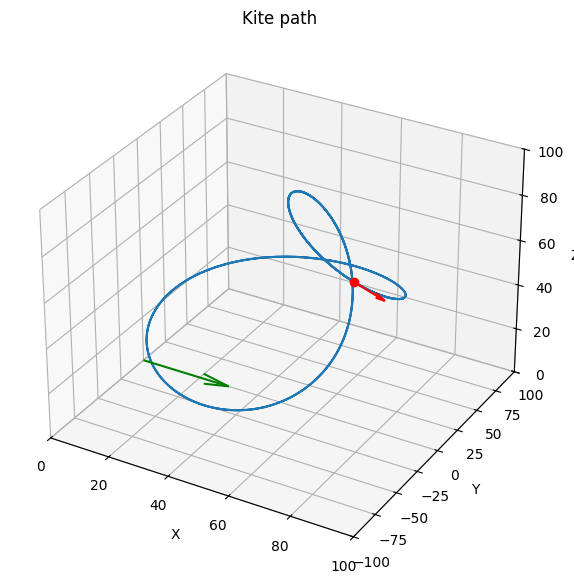

In [43]:
# %matplotlib widget

current = [2,0,0] # wind in x direction

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection = '3d')

p = 3.8
p_start = path(p)
pp_start = path_p(p)
print(pp_start)

ax.plot(x, y, z)
ax.plot(p_start[0], p_start[1], p_start[2], 'ro') # start point
ax.quiver(p_start[0], p_start[1], p_start[2], pp_start[0], pp_start[1], pp_start[2], length=0.5, color='r') # tangent at start point
ax.quiver(0,0,0, current[0], current[1], current[2], length=15, color='g')

ax.set_xlim(0, 100)
ax.set_ylim(-100, 100)
ax.set_zlim(0, 100)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# plt.ion()
plt.title("Kite path")
plt.show()

### test simulation

In [73]:
# Set parsams
p0 = 0
pdot0 = 0.2
t_step = 0.02
v_current_i = np.array([1.5,0,0])
rho = 1025
S = 4.9*1.5 #TODO from image and known width
m = 2700    # from website
g = 9.81
vol = m/rho # for neutral buoyancy

p = p0
pdot = pdot0

x0 = [p0, pdot0]
t_range = (0, 200)

# Lists to store results
ts = []
ps = []
pdots = []
pdotdots = []

alphas = []
v_kite_abss = []
v_rel_abss = []
F_aero_cs = []
F_aero_ss = []
F_aero_is = []
F_thethers = []

#   print("\nt:", round(t,4), "p:", round(p,4))
#     print(alpha_ic, v_kite_i, np.linalg.norm(v_kite_i), v_rel_i, v_rel_s, v_rel_c, v_rel_abs)
#     print(F_aero_c, F_aero_s, F_aero_i, pdot, pdotdot)


def kiteDynamics(t, x):
    # print(t)
    p = x[0]
    pdot = x[1]

    r = path(p)
    r_p = path_p(p)
    r_pp = path_pp(p)

    # TODO: pre calculate and use as functions
    # Stability basis
    e1 = r_p / np.linalg.norm(r_p)
    e3 = -r / np.linalg.norm(r)
    e2 = np.linalg.cross(e3,e1) #TODO or reverse?
    e2 /= np.linalg.norm(e2) # Does it need to be normalized?

    # print(e1, e2, e3)

    # Rot matrices 
    # R_si = np.array([e1,e2,e3])
    R_si = np.column_stack([e1, e2, e3])

    # print(R_si)

    # Relative water velocity
    v_kite_i = r_p * pdot
    v_rel_i = v_current_i - v_kite_i

    v_rel_s = R_si.T @ v_rel_i

    alpha_ic = np.atan2(-v_rel_s[2], -v_rel_s[0])# angle between axis e1 and v_rel_s
    # print(v_rel_s)
    v_rel_c = np.array([math.sqrt(v_rel_s[2]**2 + v_rel_s[0]**2), 0, 0])

    v_rel_abs = v_rel_c[0]

    # Forces in current frame
    alpha = alpha_ic #TODO

    F_L = 0.5 * rho * v_rel_abs**2 * S * C_L(alpha)
    F_D = 0.5 * rho * v_rel_abs**2 * S * C_D(alpha)

    F_aero_c = np.array([-F_D, 0, -F_L])

    F_aero_s = R_sc(-alpha_ic).T @ F_aero_c #TODO: check alpha sign -/+??

    F_aero_i = R_si @ F_aero_s

    # Forces in inertial frame
    g_i = np.array([0, 0, -g])
    F_mg = m * g_i # gravity force

    z_i = np.array([0 ,0, 1])
    F_b = rho * vol * g * z_i # buoyancy force

    F_tot_i = F_aero_i + F_mg + F_b # thether force unknown here

    # print(F_aero_i, F_mg, F_b)

    #
    pdotdot = (np.dot(e1, F_tot_i) - m * (np.dot(e1, r_pp) * pdot**2)) / (m * np.linalg.norm(r_p))

    F_thether = m * (np.dot(e3, r_pp) * pdot**2) - np.dot(e3, F_tot_i)

    # Store results
    # print("t ", t)
    # print("p ", p)
    ts.append(t)
    ps.append(p)
    pdots.append(pdot)
    pdotdots.append(pdotdot)
    alphas.append(alpha_ic)
    v_kite_abss.append(np.linalg.norm(v_kite_i))
    v_rel_abss.append(v_rel_abs)
    F_aero_cs.append(F_aero_c)
    F_aero_ss.append(F_aero_s)
    F_aero_is.append(F_aero_i)
    F_thethers.append(F_thether)

    # debug prints
    # print(pdotdot, F_thether)

    # print(v_rel_abs, alpha, F_aero_c, F_aero_s, pdot, pdotdot)

    # print("\nt:", round(t,4), "p:", round(p,4))
    # print(alpha_ic, v_kite_i, np.linalg.norm(v_kite_i), v_rel_i, v_rel_s, v_rel_c, v_rel_abs)
    # print(F_aero_c, F_aero_s, F_aero_i, pdot, pdotdot)

    # print(f"{alpha_ic}\t{v_kite_i}\t{v_rel_i}\t{v_rel_s}\t{v_rel_c}\t{v_rel_abs}")
    # print(f"{F_aero_c}\t{F_aero_s}\t{pdot}\t{pdotdot}")
    # np.linalg.norm(r_p),
    return [pdot, pdotdot]


sol = solve_ivp(kiteDynamics, t_range, x0, max_step = t_step)



In [70]:
print(sol)
print(len(sol.y[0]))
print(len(sol.t))
print(len(ts))
print(len(ps))

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.996e-03 ...  2.000e+02  2.000e+02]
        y: [[ 0.000e+00  9.972e-04 ...  2.115e+01  2.115e+01]
            [ 5.000e-01  4.992e-01 ...  7.784e-02  7.787e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 60008
     njev: 0
      nlu: 0
10002
10002
60008
60008


### Plots of motion

60008
60008


Text(0.5, 0, 'Time [s]')

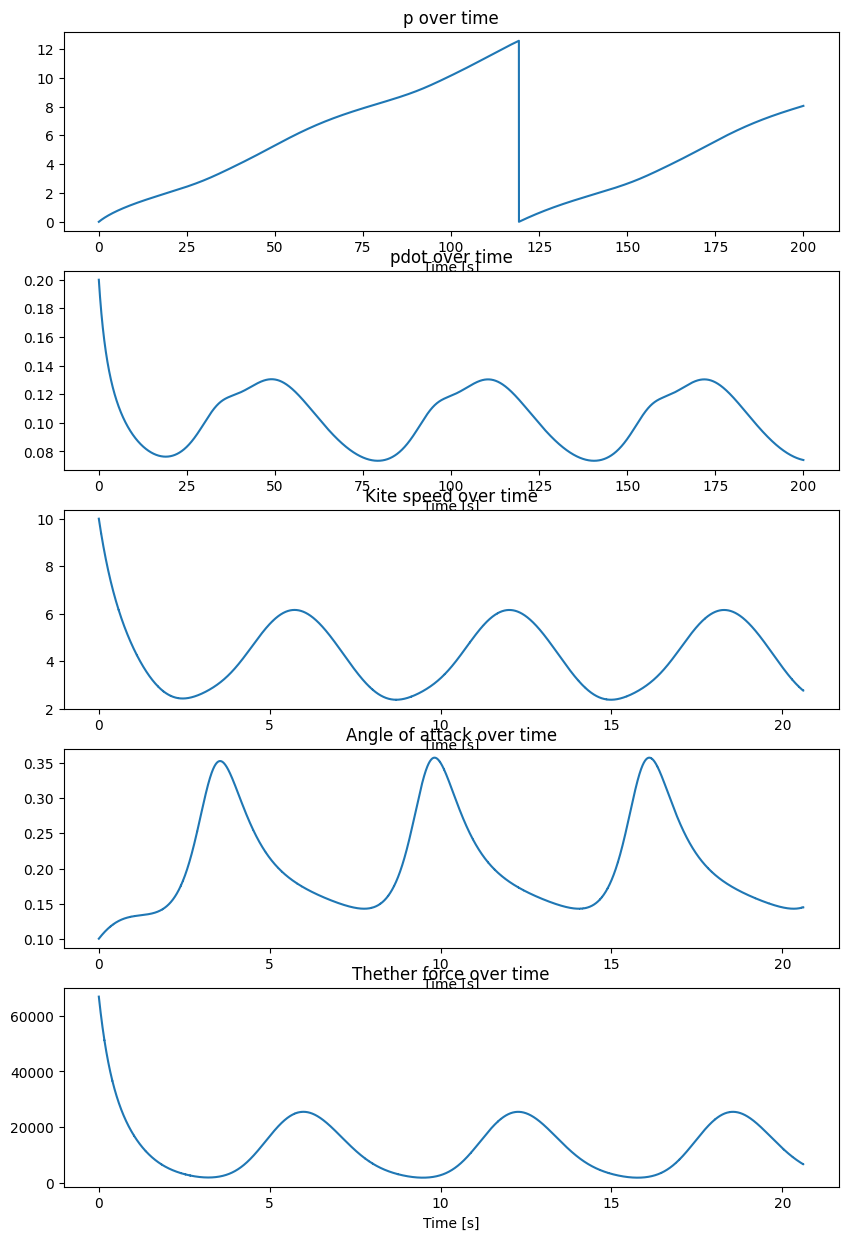

In [ ]:
print(len(ps))
print(len(ts))

fig = plt.subplots(5, 1, figsize=(10, 15))

plt.subplot(5,1,1)
plt.plot(sol.t, sol.y[0] % (4*math.pi))
plt.title("p over time")
plt.xlabel("Time [s]")

plt.subplot(5,1,2)
plt.plot(sol.t, sol.y[1])
plt.title("pdot over time")
plt.xlabel("Time [s]")

plt.subplot(5,1,3)
plt.plot(ts, v_kite_abss)
plt.title("Kite speed over time")
plt.xlabel("Time [s]")

plt.subplot(5,1,4)
plt.plot(ts, alphas)
plt.title("Angle of attack over time")
plt.xlabel("Time [s]")

plt.subplot(5,1,5)
plt.plot(ts, F_thethers)
plt.title("Thether force over time")
plt.xlabel("Time [s]")

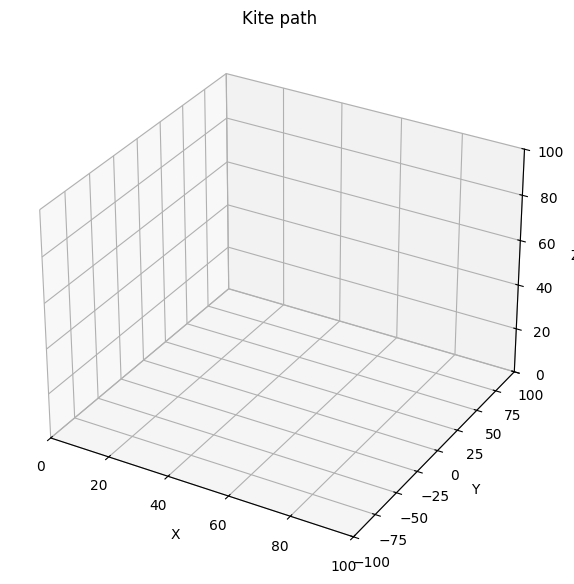

In [46]:

import matplotlib.animation as animation

ps = sol.y[0]
pps = sol.y[1]

coords = np.array([path(p) for p in ps])
x = coords[:,0]
y = coords[:,1]
z = coords[:,2]

current = [2,0,0] # wind in x direction

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection = '3d')

ax.set_xlim(0, 100)
ax.set_ylim(-100, 100)
ax.set_zlim(0, 100)

line, = ax.plot([], [], [], lw=2)
point, = ax.plot([], [], [], 'ro')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Kite path")

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point

def animate(i):
    p = ps[i]
    pdot = pps[i]
    coord = path(p)
    line.set_data(x[:i], y[:i])
    line.set_3d_properties(z[:i])
    point.set_data(coord[0], coord[1])
    point.set_3d_properties(coord[2])
    return line, point


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(ps), interval=50, blit=False)
plt.show()

anim


In [47]:
anim.save("animation.mp4", fps=30)

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

NameError: name 'cm' is not defined

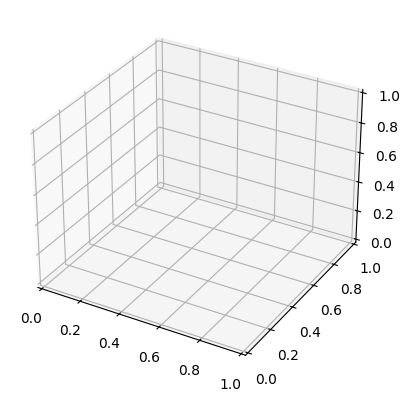

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib.animation import FuncAnimation



fig = plt.figure()
ax = plt.axes(projection='3d')


def update(frame, fig):
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    # add random shift in z directions
    Z = np.sin(R)+np.random.random_sample()
    if len(fig.axes[0].collections) != 0:
        fig.axes[0].collections = []
        surf = fig.axes[0].plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    else:
        surf = fig.axes[0].plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_zlim(-1.5, 1.5)

    fig.canvas.draw()
    return surf,
    
ani = FuncAnimation(fig, update, fargs=[fig], frames=5, blit=True)

In [75]:
print(math.atan2(-(-2),-(-3))*57.2958)
print(math.atan2(-(2),-(-3))*57.2958)

33.69007957234072
-33.69007957234072
